In [3]:
import numpy as np
import matplotlib.pyplot as plt
# gradient checking
from scipy.optimize import check_grad
# system of linear equations
from numpy.linalg import solve
from numpy.linalg import norm

from scipy import optimize, sparse
from scipy.special import expit

In [31]:
import numbers
#import warnings

from sklearn.linear_model.base import LinearClassifierMixin, SparseCoefMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

#from sklearn.utils import check_array, check_consistent_length, compute_class_weight
#from sklearn.utils import check_random_state
from sklearn.utils.extmath import (log_logistic, safe_sparse_dot, softmax, squared_norm)
#from sklearn.utils.extmath import row_norms
from sklearn.utils.fixes import logsumexp
#from sklearn.utils.validation import check_X_y
#from sklearn.exceptions import (NotFittedError, ConvergenceWarning, ChangedBehaviorWarning)
#from sklearn.utils.multiclass import check_classification_targets
#from sklearn.utils import Parallel, delayed, effective_n_jobs
from sklearn.externals import six
from sklearn.metrics import get_scorer

Regularized risk minimization:

$$\sum_{i=1}^N \mathrm{KL}(y_i||\mathrm{softmax}(Wx_i)) + \frac{\alpha}{2} \|W\|_\text{F}^2 \rightarrow \min_{W}$$

or

$$C \sum_{i=1}^N \mathrm{KL}(y_i||\mathrm{softmax}(Wx_i)) + \frac{1}{2} \|W\|_\text{F}^2 \rightarrow \min_{W}$$

where $C = \frac{1}{\alpha}$.

In [56]:
def _loss_and_grad(w, X, Y, alpha):
    """
    Parameters
    ----------
    w : ndarray, shape (n_classes * n_features,) or (n_classes * (n_features + 1),)
        Coefficient vector.
    X : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training data.
    Y : ndarray, shape (n_samples, n_classes)
        Transformed labels according to the output of LabelBinarizer.
    alpha : float
        Regularization parameter. alpha is equal to 1 / C.
    Returns
    -------
    loss : float
    grad : ndarray, shape (n_classes * (n_features + 1),)
    """
    n_classes = Y.shape[1]
    n_features = X.shape[1]
    fit_intercept = (w.size == n_classes * (n_features + 1))
    
    w = w.reshape(n_classes, -1)
    if fit_intercept:
        intercept = w[:, -1]
        w = w[:, :-1]
    else:
        intercept = 0
    
    p = safe_sparse_dot(X, w.T)
    if fit_intercept:
        p += intercept[np.newaxis,:]
    p -= logsumexp(p, axis=1)[:, np.newaxis]
    
    # compute loss
    loss = -(Y * p).sum()
    loss += 0.5 * alpha * squared_norm(w)
    
    p = np.exp(p)

    # compute gradient
    grad = np.zeros((n_classes, n_features + bool(fit_intercept)), dtype=X.dtype)
    diff = (p - Y)
    grad[:, :n_features] = safe_sparse_dot(diff.T, X)
    grad[:, :n_features] += alpha * w
    
    if fit_intercept:
        grad[:, -1] = diff.sum(axis=0)
        
    return loss, grad.ravel()


Gradient checking

In [6]:
N = 10
d = 3 # n_features

X_toy = np.random.randn(N,d)

K = 4 # n_classes

y_toy = np.arange(N)%K
lbin = LabelBinarizer()
Y_toy = lbin.fit_transform(y_toy) # one-hot encoding of y_toy

alpha = 0.1 # regularization constant

func = lambda w: _loss_and_grad(w, X_toy, Y_toy, alpha)[0]
grad = lambda w: _loss_and_grad(w, X_toy, Y_toy, alpha)[1]

w0 = np.random.randn(K*(d+1),)

difference = check_grad(func, grad, w0)
print(difference) # should be small

9.968216979493663e-07


In [39]:
def softmax_regression_path(X, y, Cs=5, fit_intercept=True,  max_iter=100, tol=1e-4):
    """
    Parameters
    ----------
    X : array-like or sparse matrix, shape (n_samples, n_features)
        Input data.
    y : array-like, shape (n_samples,) or (n_samples, n_targets)
        Input data, target values.
    Cs : int | array-like, shape (n_cs,)
        List of values for the regularization parameter or integer specifying
        the number of regularization parameters that should be used. In this
        case, the parameters will be chosen in a logarithmic scale between
        1e-4 and 1e4.
    fit_intercept : bool
        Whether to fit an intercept for the model. In this case the shape of
        the returned array is (n_cs, n_features + 1).
    max_iter : int
        Maximum number of iterations for the solver.
    tol : float
        Stopping criterion. For the newton-cg and lbfgs solvers, the iteration
        will stop when ``max{|g_i | i = 1, ..., n} <= tol``
        where ``g_i`` is the i-th component of the gradient.
    Returns
    -------
    coefs : ndarray, shape (n_classes, n_cs, n_features) or (n_classes, n_cs, n_features + 1)
        List of coefficients.
    Cs : ndarray
        Grid of Cs used for cross-validation.
    """
    _, n_features = X.shape
    
    if isinstance(Cs, numbers.Integral):
        Cs = np.logspace(-4, 4, Cs)

    classes = np.unique(y)
    n_classes = classes.size

    # compute one-hot encoding of the class labels
    lbin = LabelBinarizer()
    Y = lbin.fit_transform(y)

    func_and_grad = lambda x, *args: _loss_and_grad(x, *args)

    # initialize parameters
    w0 = np.zeros((classes.size, n_features + int(fit_intercept)), order='F', dtype=X.dtype)
    w0 = w0.ravel()
    
    # estimate parameters for each value of C
    coefs = list()   
    for i, C in enumerate(Cs):
        w, _, _ = optimize.fmin_l_bfgs_b(func_and_grad, w0, fprime=None, args=(X, Y, 1./C), pgtol=tol, maxiter=max_iter)
        w = np.reshape(w, (n_classes, -1))
        coefs.append(w.copy())

    return coefs, np.array(Cs)


In [32]:
#class SoftmaxRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
class SoftmaxRegression(BaseEstimator):
    """
    Parameters
    ----------
    tol : float, default: 1e-4
        Tolerance for stopping criteria.
    C : float, default: 1.0
        Inverse of regularization strength; must be a positive float.
        Smaller values specify stronger regularization.
    fit_intercept : bool, default: True
        Specifies if a constant (a.k.a. bias or intercept) should be
        added to the decision function.
    max_iter : int, default: 100
        Maximum number of iterations taken for the solvers to converge.
    Attributes
    ----------
    coef_ : array, shape (n_classes, n_features)
        Coefficient of the features in the decision function.
    intercept_ : array, shape (n_classes,)
        Intercept (a.k.a. bias) added to the decision function.
        If `fit_intercept` is set to False, the intercept is set to zero.
    --------
    """
    
    def __init__(self, C=1.0, fit_intercept=True, tol=1e-4, max_iter=100):

        self.C = C
        self.fit_intercept = fit_intercept
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, X, y):
        """
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape (n_samples,) or (n_samples, n_targets)
            Target vector relative to X.
        Returns
        -------
        self : object
        """
        #X, y = check_X_y(X, y, accept_sparse='csr', order="C")
        #check_classification_targets(y)
                
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        n_samples, n_features = X.shape
        
        # estimate parameters for a single value of C    
        fold_ = softmax_regression_path(X, y, Cs=[self.C], fit_intercept=self.fit_intercept, 
                                              max_iter=self.max_iter, tol=self.tol) 
        fold_coefs_ = fold_[0]
        self.coef_ = fold_coefs_[0]

        self.intercept_ = np.zeros(n_classes)
        if self.fit_intercept:
            self.intercept_ = self.coef_[:, -1]
            self.coef_ = self.coef_[:, :-1]
            
        return self

    def predict_proba(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        Returns
        -------
        T : array-like, shape (n_samples, n_features)
            Returns the probability of the sample for each class in the model,
            where classes are ordered as they are in ``self.classes_``.
        """
        decision = self.decision_function(X)
        return softmax(decision, copy=False)

    def predict_log_proba(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        Returns
        -------
        T : array-like, shape (n_samples, n_features)
            Returns the log-probability of the sample for each class in the
            model, where classes are ordered as they are in ``self.classes_``.
        """
        return np.log(self.predict_proba(X))
    

    def decision_function(self, X):
        """
        Parameters
        ----------
        X : array_like or sparse matrix, shape (n_samples, n_features)
            Samples.
        Returns
        -------
        array, shape=(n_samples, n_classes)
            Confidence scores per (sample, class) combination.
        """
        #X = check_array(X, accept_sparse='csr')
        scores = safe_sparse_dot(X, self.coef_.T, dense_output=True) + self.intercept_[np.newaxis,:]    
        return scores
    

    def predict(self, X):
        """
        Parameters
        ----------
        X : array_like or sparse matrix, shape (n_samples, n_features)
            Samples.
        Returns
        -------
        C : array, shape (n_samples)
            Predicted class label per sample.
        """
        scores = self.decision_function(X)
        indices = scores.argmax(axis=1)
        return self.classes_[indices]

    

    def score(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Test samples.
        y : array-like, shape (n_samples,)
            True labels for X.
        Returns
        -------
        score : float
            Score of self.predict(X) wrt. y.
        """
        scoring = 'accuracy'
        if isinstance(scoring, six.string_types):
            scoring = get_scorer(scoring)
        return scoring(self, X, y)

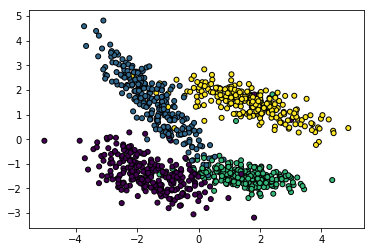

In [148]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=2, class_sep=1.5,
                           n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=4, random_state=7)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

In [149]:
print(X.shape, y.shape)

(1000, 2) (1000,)


In [150]:
is_object_oriented = True # object-oriented implementation

In [151]:
bias_term = True # if 1: score = v*x + b = dot([v b], [x 1]); else: score = w*x;

In [152]:
if is_object_oriented:
    clf = SoftmaxRegression(C=10, fit_intercept=bias_term)
    clf.fit(X, y)
    print(clf.coef_.shape, clf.intercept_.shape)
else:
    fold_ = softmax_regression_path(X, y, Cs=[10], fit_intercept=bias_term)
    coef_ = fold_[0][0]
    if bias_term:
        intercept_ = coef_[:, -1]
        coef_ = coef_[:, :-1]
    else:
        n_classes = coef_.shape[0]
        intercept_ = np.zeros(n_classes)
    print(coef_.shape, intercept_.shape)

(4, 2) (4,)


In [153]:
h = 0.05  # step size in the mesh

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_test = np.c_[xx.ravel(), yy.ravel()]

In [154]:
if is_object_oriented:
    Z = clf.predict(X_test).reshape(xx.shape)
else:
    scores = np.dot(X_test, coef_.T) + intercept_[np.newaxis,:] 
    Z = np.argmax(scores, axis=1).reshape(xx.shape)

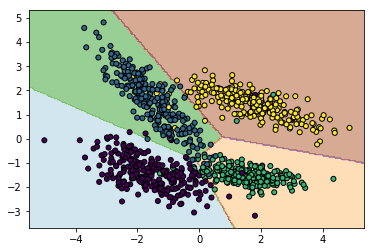

In [155]:
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=.5)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

Estimating accuracy using cross-validation to select the best regularization constant

In [156]:
from sklearn.model_selection import cross_val_score

C = [1, 2, 5, 10, 100] # = 1/alpha

accuracy = []
for C_ in C:
    clf = SoftmaxRegression(C=C_, max_iter=200)
    accuracy.append(np.mean(cross_val_score(clf, X, y, cv=5)))
    
print(accuracy)

[0.951, 0.95, 0.95, 0.951, 0.9530000000000001]


In [157]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[1, 5, 10, 100]}
clf = SoftmaxRegression(max_iter=200)
clf_gridsearch = GridSearchCV(clf, parameters, cv=5, n_jobs=4)
clf_gridsearch.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SoftmaxRegression(C=1.0, fit_intercept=True, max_iter=200, tol=0.0001),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': [1, 5, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [158]:
best_clf = clf_gridsearch.best_estimator_
print(type(best_clf))

<class '__main__.SoftmaxRegression'>


In [159]:
print(best_clf.score(X,y))

0.953
